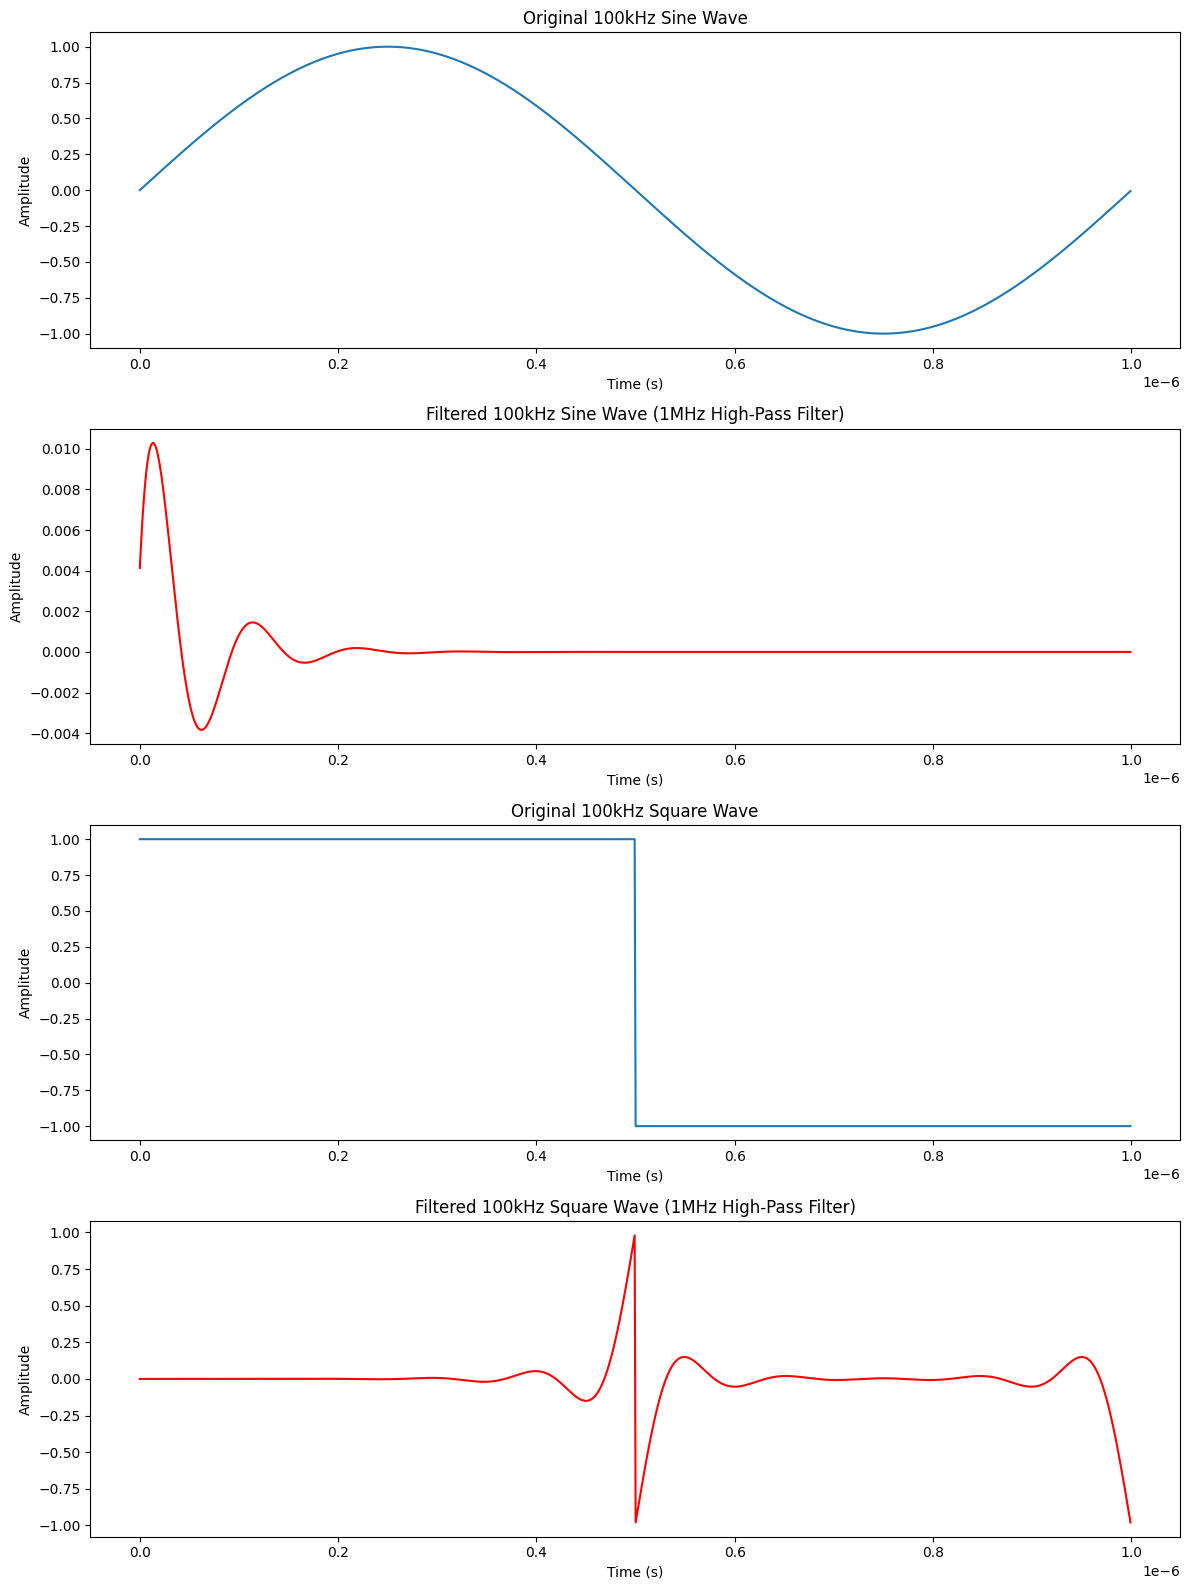

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, square

# High-pass filter 생성 함수
def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs  # 나이퀴스트 주파수
    normal_cutoff = cutoff / nyquist  # 정규화된 차단 주파수
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# High-pass filter 적용 함수
def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# 샘플링 주파수 및 신호 생성
fs = 1e9  # 샘플링 주파수 (1 MHz)
t = np.linspace(0, 1e-2, int(fs*0.01), endpoint=False)  # 10 밀리초 동안 샘플링

# 100 kHz 사인파와 100 kHz 사각파 신호 생성
sine_wave = np.sin(2 * np.pi * 100e4 * t)  # 100 kHz 사인파
square_wave = square(2 * np.pi * 100e4 * t)  # 100 kHz 사각파

# 차단 주파수 1 kHz로 필터 적용 (High-pass filter)
cutoff = 1e7  # 1 kHz 차단 주파수
filtered_sine = butter_highpass_filter(sine_wave, cutoff, fs)
filtered_square = butter_highpass_filter(square_wave, cutoff, fs)

# 결과 시각화
plt.figure(figsize=(12, 16))

# 원본 100kHz 사인파
plt.subplot(4, 1, 1)
plt.plot(t[:1000], sine_wave[:1000])
plt.title('Original 100kHz Sine Wave')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 필터링된 100kHz 사인파
plt.subplot(4, 1, 2)
plt.plot(t[:1000], filtered_sine[:1000], color='red')
plt.title('Filtered 100kHz Sine Wave (1MHz High-Pass Filter)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 원본 100kHz 사각파
plt.subplot(4, 1, 3)
plt.plot(t[:1000], square_wave[:1000])
plt.title('Original 100kHz Square Wave')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 필터링된 100kHz 사각파
plt.subplot(4, 1, 4)
plt.plot(t[:1000], filtered_square[:1000], color='red')
plt.title('Filtered 100kHz Square Wave (1MHz High-Pass Filter)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


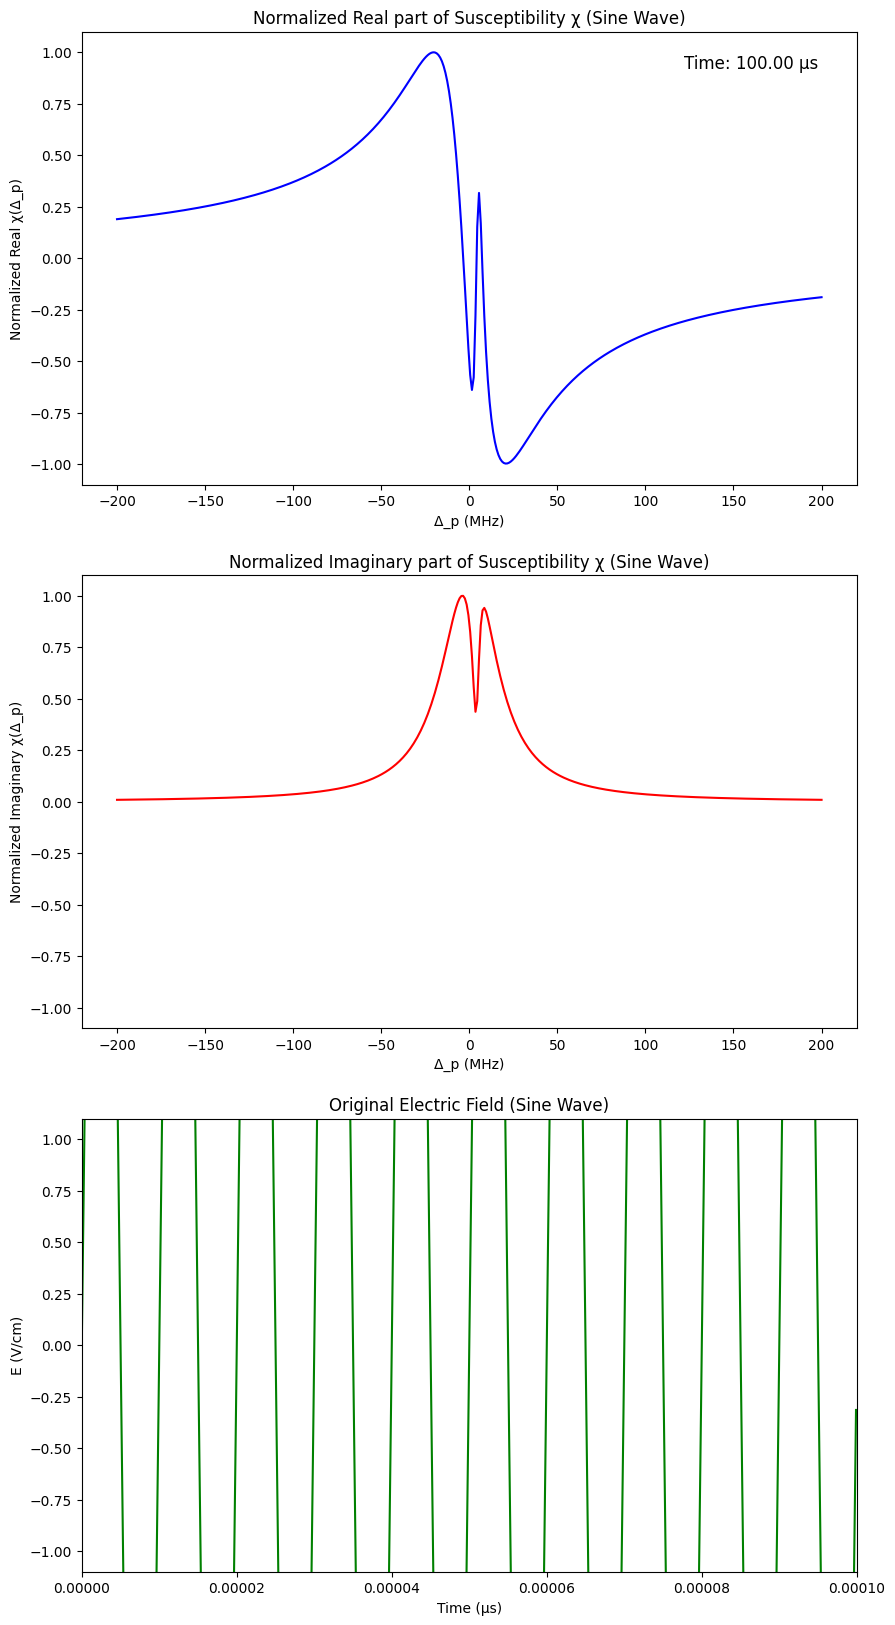

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from matplotlib.animation import FuncAnimation

# 상수 및 변수 정의
hbar = 1.054571817e-34  # Planck constant (J·s)
c = 3e8  # light speed (m/s)
d_eg = 1.46513e-29  # excited state dipole moment
N0 = 3.93e23  # 원자 수 밀도
V = 3.64e-5  # volume (m^3)
epsilon_0 = 8.854e-12  # vacuum permeability (F/m)
T = 300  # temperature (K)
k_B = 1.38e-23  # Boltzman constant
m = 85.47 * 1.660539066e-27  # Rubidium mass (kg)

alpha = 5.914e6  # polarizability of the Rydberg state (MHz / (V^2/cm^2))
frequency = 100e3  # 100 kHz
E_amplitude = 5  # amplitude of the electric field

omega_p = 3.774e14  # 795 nm probe frequency (Hz)
omega_c = 6.316e14  # 475 nm coupling frequency (Hz)
Omega_p = 2 * np.pi * 1e4  # probe laser Rabi frequency (Hz)
Omega_c = 2 * np.pi * 1.62 * 1e6  # coupling laser Rabi frequency (Hz)

gamma_p = 1e6  # probe laser linewidth
gamma_c = 1e6  # coupling laser linewidth
gamma_rel = (gamma_p + gamma_c) / 2

Gamma_e = 2 * np.pi * 5.75e6
Gamma_r = 1 / 7.06e-05

Delta_p_vals = np.linspace(-200, 200, 400)  # MHz
time_vals = np.linspace(0, 1e-4, 1000)  # 시간 범위, 0~100us

# High-pass filter 생성 함수
def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs  # 나이퀴스트 주파수
    normal_cutoff = cutoff / nyquist  # 정규화된 차단 주파수
    b, a = butter(order, normal_cutoff, btype='high', analog=False)  # 고역통과 필터로 변경
    return b, a

# High-pass filter 적용 함수
def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# 신호 생성 (사인파)
E_signal = E_amplitude * np.sin(2 * np.pi * frequency * time_vals)

# 고역 통과 필터 적용 (E_signal에 대해 필터링)
fs = 1e7  # 샘플링 주파수 (10 MHz)
cutoff = 1e5  # 차단 주파수 100 kHz
E_filtered = butter_highpass_filter(E_signal, cutoff, fs)

# Susceptibility 계산 함수
def calculate_chi(E):
    chi_real_vals = []
    chi_imag_vals = []
    Delta_c = (2 * np.pi * (-1/2) * alpha * E ** 2)
    
    for dp in Delta_p_vals:
        Delta_p = dp * 1e6  # MHz to Hz
        denominator = (1/2) * Gamma_e + gamma_p - 1j * Delta_p +  (Omega_c**2/4) / (
                    (1/2) * Gamma_r + gamma_rel - 1j * (Delta_p + Delta_c) )
        chi = (1j * N0 * d_eg ** 2) / (epsilon_0 * hbar * denominator)
        chi_real_vals.append(np.real(chi))
        chi_imag_vals.append(np.imag(chi))
    
    # 정규화
    max_real = np.max(np.abs(chi_real_vals))
    chi_real_vals_normalized = [x / max_real for x in chi_real_vals]

    max_imag = np.max(np.abs(chi_imag_vals))
    chi_imag_vals_normalized = [x / max_imag for x in chi_imag_vals]
    
    return chi_real_vals_normalized, chi_imag_vals_normalized

# 그래프 업데이트 함수 (애니메이션용)
def update(frame, line_real, line_imag, time_text, line_E_signal, E_filtered, E_signal, wave_type='sine'):
    t = time_vals[frame]
    E = E_filtered[frame]  # EIT 신호에 적용된 필터링된 전기장
    
    # EIT 신호 계산
    chi_real_vals_normalized, chi_imag_vals_normalized = calculate_chi(E)
    
    # EIT 신호 업데이트 (필터링된 전기장 사용)
    line_real.set_ydata(chi_real_vals_normalized)
    line_imag.set_ydata(chi_imag_vals_normalized)
    
    # **수정된 부분: 실시간으로 사인파 그리기**
    # 원본 사인파 신호 업데이트 (필터링되지 않은 원본 신호)
    line_E_signal.set_data(time_vals[:frame], E_signal[:frame])
    
     # frame이 0일 때의 문제 해결: frame > 0일 때만 xlim 업데이트
    if frame > 0:
        ax3.set_xlim(0, time_vals[frame])  # x축 범위를 실시간으로 업데이트
    
    
    # 시간 텍스트 업데이트
    time_text.set_text(f'Time: {t * 1e6:.2f} µs')  # 시간을 마이크로초로 표시
    
    return line_real, line_imag, time_text, line_E_signal


# 그래프 그리기 및 애니메이션 설정
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 20))

# EIT 신호 (필터링된 전기장에 대한)
ax1.set_title('Normalized Real part of Susceptibility χ (Sine Wave)')
ax1.set_xlabel('Δ_p (MHz)')
ax1.set_ylabel('Normalized Real χ(Δ_p)')
line_real, = ax1.plot(Delta_p_vals, np.zeros_like(Delta_p_vals), 'b')

ax2.set_title('Normalized Imaginary part of Susceptibility χ (Sine Wave)')
ax2.set_xlabel('Δ_p (MHz)')
ax2.set_ylabel('Normalized Imaginary χ(Δ_p)')
line_imag, = ax2.plot(Delta_p_vals, np.zeros_like(Delta_p_vals), 'r')

# 새로운 전기장 신호 그래프 (원본 사인파)
ax3.set_title('Original Electric Field (Sine Wave)')
ax3.set_xlabel('Time (µs)')
ax3.set_ylabel('E (V/cm)')
line_E_signal, = ax3.plot([], [], 'g')

# ** 축 범위 조정 **
ax1.set_ylim([-1.1, 1.1])
ax2.set_ylim([-1.1, 1.1])
ax3.set_ylim([-1.1, 1.1])

# 시간 표시 텍스트 추가 (우측 상단)
time_text = ax1.text(0.95, 0.95, '', transform=ax1.transAxes, fontsize=12, ha='right', va='top')

# 애니메이션 생성
ani_sine = FuncAnimation(
    fig, update, frames=len(time_vals), fargs=(line_real, line_imag, time_text, line_E_signal, E_filtered, E_signal, 'sine'), interval=10)

# 애니메이션을 GIF로 저장
ani_sine.save('eit_signal_with_filtered_and_original_sine_wave.gif', writer='pillow')

plt.show()


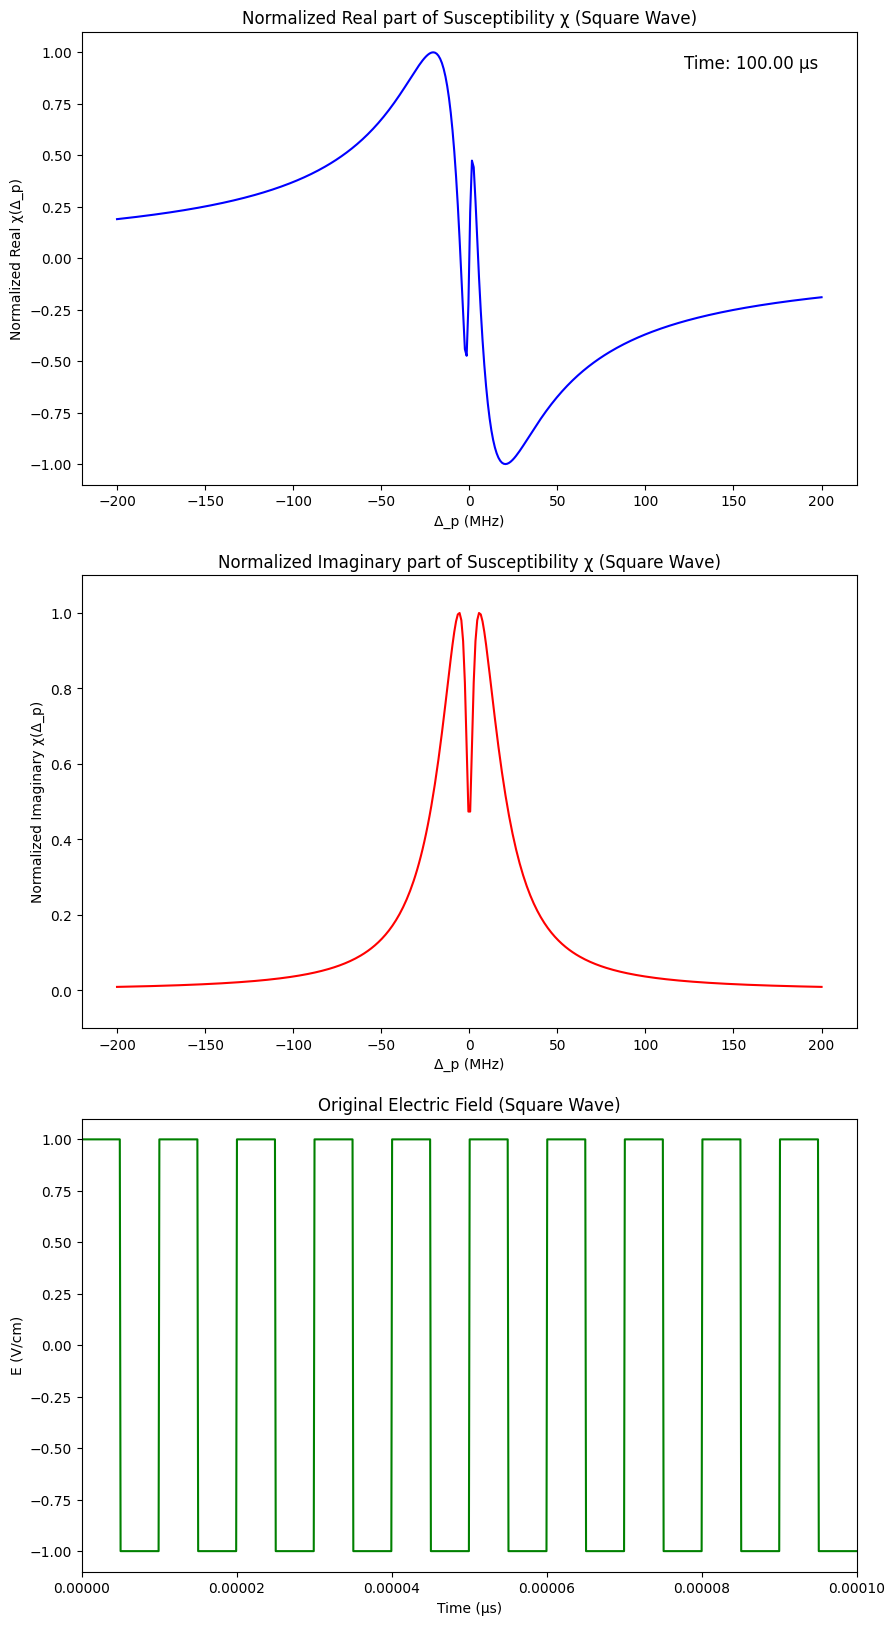

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, square  # square 함수 추가
from matplotlib.animation import FuncAnimation

# 상수 및 변수 정의
hbar = 1.054571817e-34  # Planck constant (J·s)
c = 3e8  # light speed (m/s)
d_eg = 1.46513e-29  # excited state dipole moment
N0 = 3.93e23  # 원자 수 밀도
V = 3.64e-5  # volume (m^3)
epsilon_0 = 8.854e-12  # vacuum permeability (F/m)
T = 300  # temperature (K)
k_B = 1.38e-23  # Boltzman constant
m = 85.47 * 1.660539066e-27  # Rubidium mass (kg)

alpha = 5.914e6  # polarizability of the Rydberg state (MHz / (V^2/cm^2))
frequency = 100e3  # 100 kHz (사각파의 주파수)
E_amplitude = 1  # 전기장의 진폭

omega_p = 3.774e14  # 795 nm probe frequency (Hz)
omega_c = 6.316e14  # 475 nm coupling frequency (Hz)
Omega_p = 2 * np.pi * 1e4  # probe laser Rabi frequency (Hz)
Omega_c = 2 * np.pi * 1.62 * 1e6  # coupling laser Rabi frequency (Hz)

gamma_p = 1e6  # probe laser linewidth
gamma_c = 1e6  # coupling laser linewidth
gamma_rel = (gamma_p + gamma_c) / 2

Gamma_e = 2 * np.pi * 5.75e6
Gamma_r = 1 / 7.06e-05

Delta_p_vals = np.linspace(-200, 200, 400)  # MHz
time_vals = np.linspace(0, 1e-4, 1000)  # 시간 범위, 0~100us

# High-pass filter 생성 함수
def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs  # 나이퀴스트 주파수
    normal_cutoff = cutoff / nyquist  # 정규화된 차단 주파수
    b, a = butter(order, normal_cutoff, btype='high', analog=False)  # 고역통과 필터로 변경
    return b, a

# High-pass filter 적용 함수
def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# 신호 생성 (사각파로 변경)
E_signal = E_amplitude * square(2 * np.pi * frequency * time_vals)  # 100 kHz 사각파 생성

# 고역 통과 필터 적용 (E_signal에 대해 필터링)
fs = 1e7  # 샘플링 주파수 (10 MHz)
cutoff = 1e6  # 차단 주파수 100 kHz
E_filtered = butter_highpass_filter(E_signal, cutoff, fs)

# Susceptibility 계산 함수
def calculate_chi(E):
    chi_real_vals = []
    chi_imag_vals = []
    Delta_c = (2 * np.pi * (-1/2) * alpha * E ** 2)
    
    for dp in Delta_p_vals:
        Delta_p = dp * 1e6  # MHz to Hz
        denominator = (1/2) * Gamma_e + gamma_p - 1j * Delta_p +  (Omega_c**2/4) / (
                    (1/2) * Gamma_r + gamma_rel - 1j * (Delta_p + Delta_c) )
        chi = (1j * N0 * d_eg ** 2) / (epsilon_0 * hbar * denominator)
        chi_real_vals.append(np.real(chi))
        chi_imag_vals.append(np.imag(chi))
    
    # 정규화
    max_real = np.max(np.abs(chi_real_vals))
    chi_real_vals_normalized = [x / max_real for x in chi_real_vals]

    max_imag = np.max(np.abs(chi_imag_vals))
    chi_imag_vals_normalized = [x / max_imag for x in chi_imag_vals]
    
    return chi_real_vals_normalized, chi_imag_vals_normalized

# 그래프 업데이트 함수 (애니메이션용)
def update(frame, line_real, line_imag, time_text, line_E_signal, E_filtered, E_signal, wave_type='square'):
    t = time_vals[frame]
    E = E_filtered[frame]  # EIT 신호에 적용된 필터링된 전기장
    
    # EIT 신호 계산
    chi_real_vals_normalized, chi_imag_vals_normalized = calculate_chi(E)
    
    # EIT 신호 업데이트 (필터링된 전기장 사용)
    line_real.set_ydata(chi_real_vals_normalized)
    line_imag.set_ydata(chi_imag_vals_normalized)
    
    # 원본 사각파 신호 업데이트
    line_E_signal.set_data(time_vals[:frame], E_signal[:frame])
    
    # frame > 0일 때만 xlim 업데이트
    if frame > 0:
        ax3.set_xlim(0, time_vals[frame])
    
    # 시간 텍스트 업데이트
    time_text.set_text(f'Time: {t * 1e6:.2f} µs')  # 시간을 마이크로초로 표시
    
    return line_real, line_imag, time_text, line_E_signal

# 그래프 그리기 및 애니메이션 설정
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 20))

# EIT 신호 (필터링된 전기장에 대한)
ax1.set_title('Normalized Real part of Susceptibility χ (Square Wave)')
ax1.set_xlabel('Δ_p (MHz)')
ax1.set_ylabel('Normalized Real χ(Δ_p)')
line_real, = ax1.plot(Delta_p_vals, np.zeros_like(Delta_p_vals), 'b')

ax2.set_title('Normalized Imaginary part of Susceptibility χ (Square Wave)')
ax2.set_xlabel('Δ_p (MHz)')
ax2.set_ylabel('Normalized Imaginary χ(Δ_p)')
line_imag, = ax2.plot(Delta_p_vals, np.zeros_like(Delta_p_vals), 'r')

# 새로운 전기장 신호 그래프 (원본 사각파)
ax3.set_title('Original Electric Field (Square Wave)')
ax3.set_xlabel('Time (µs)')
ax3.set_ylabel('E (V/cm)')
line_E_signal, = ax3.plot([], [], 'g')

# ** 축 범위 조정 **
ax1.set_ylim([-1.1, 1.1])
ax2.set_ylim([-0.1, 1.1])
ax3.set_ylim([-1.1, 1.1])

# 시간 표시 텍스트 추가 (우측 상단)
time_text = ax1.text(0.95, 0.95, '', transform=ax1.transAxes, fontsize=12, ha='right', va='top')

# 애니메이션 생성
ani_square = FuncAnimation(
    fig, update, frames=len(time_vals), fargs=(line_real, line_imag, time_text, line_E_signal, E_filtered, E_signal, 'square'), interval=10)

# 애니메이션을 GIF로 저장
ani_square.save('eit_signal_with_filtered_and_original_square_wave, HPF 1MHz.gif', writer='pillow')

plt.show()


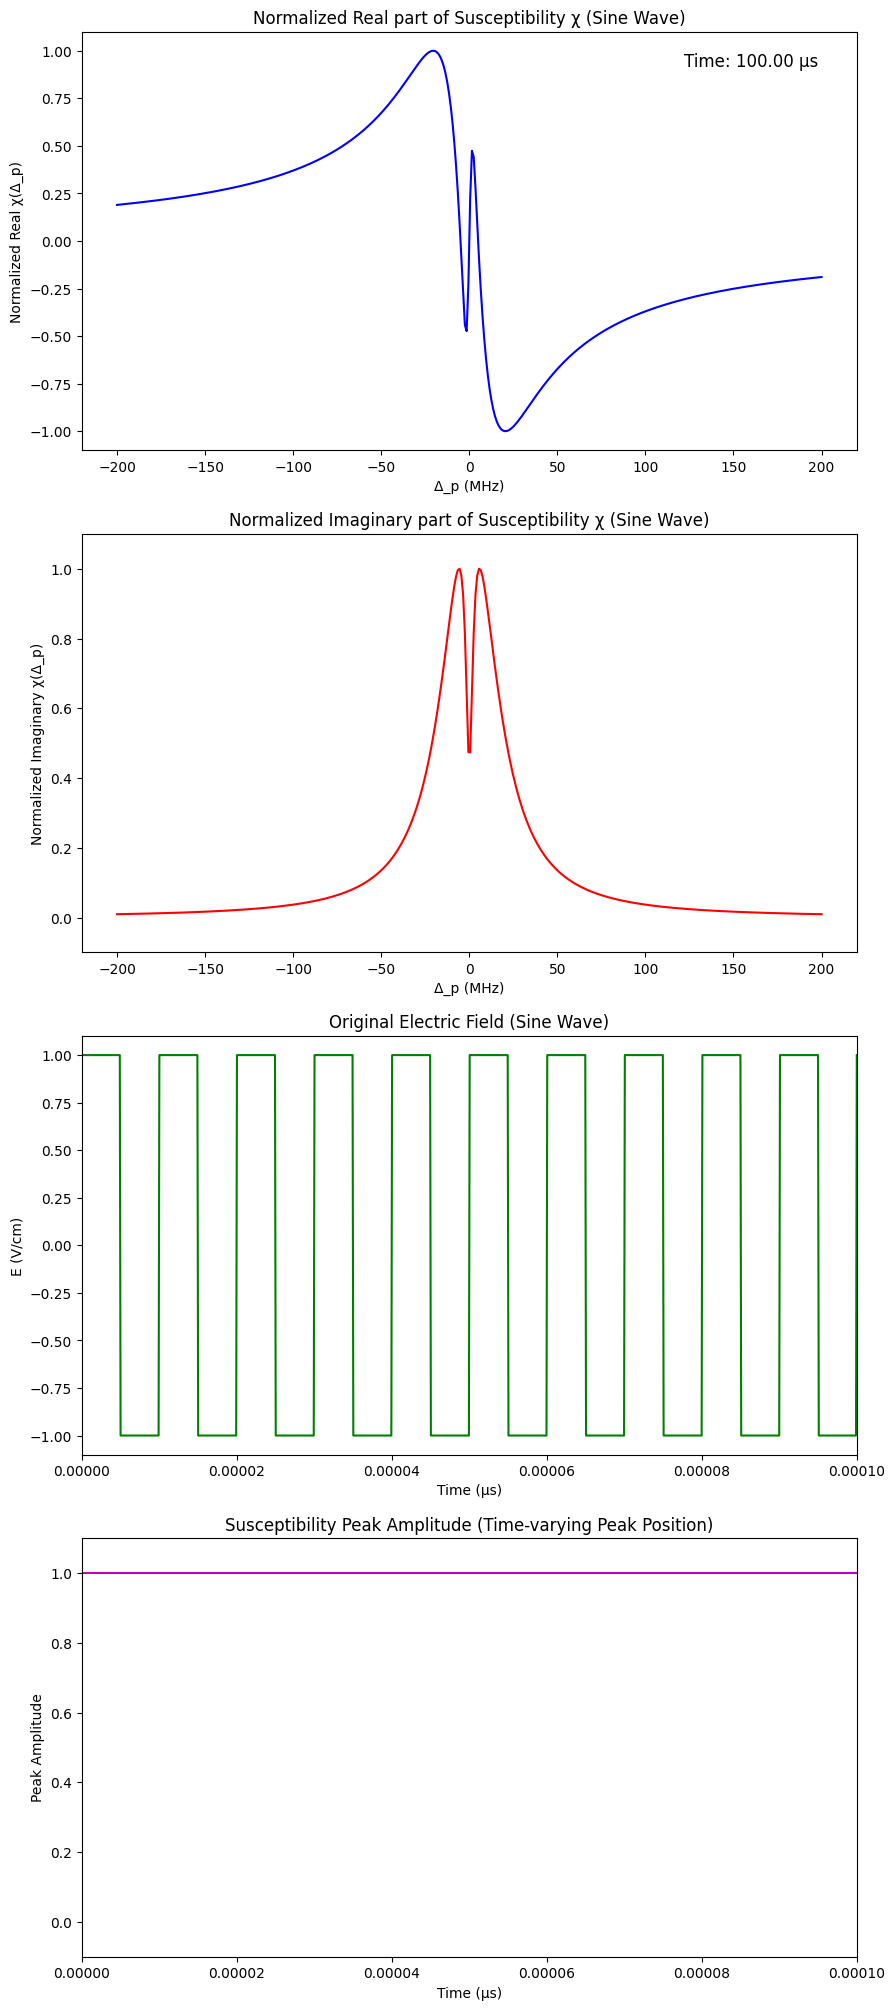

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, square  # square 함수 추가
from matplotlib.animation import FuncAnimation

# 상수 및 변수 정의
hbar = 1.054571817e-34  # Planck constant (J·s)
c = 3e8  # light speed (m/s)
d_eg = 1.46513e-29  # excited state dipole moment
N0 = 3.93e23  # 원자 수 밀도
V = 3.64e-5  # volume (m^3)
epsilon_0 = 8.854e-12  # vacuum permeability (F/m)
T = 300  # temperature (K)
k_B = 1.38e-23  # Boltzman constant
m = 85.47 * 1.660539066e-27  # Rubidium mass (kg)

alpha = 5.914e6  # polarizability of the Rydberg state (MHz / (V^2/cm^2))
frequency = 100e3  # 100 kHz (사각파의 주파수)
E_amplitude = 1  # 전기장의 진폭

omega_p = 3.774e14  # 795 nm probe frequency (Hz)
omega_c = 6.316e14  # 475 nm coupling frequency (Hz)
Omega_p = 2 * np.pi * 1e4  # probe laser Rabi frequency (Hz)
Omega_c = 2 * np.pi * 1.62 * 1e6  # coupling laser Rabi frequency (Hz)

gamma_p = 1e6  # probe laser linewidth
gamma_c = 1e6  # coupling laser linewidth
gamma_rel = (gamma_p + gamma_c) / 2

Gamma_e = 2 * np.pi * 5.75e6
Gamma_r = 1 / 7.06e-05

Delta_p_vals = np.linspace(-200, 200, 400)  # MHz
time_vals = np.linspace(0, 1e-4, 1000)  # 시간 범위, 0~100us

# High-pass filter 생성 함수
def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs  # 나이퀴스트 주파수
    normal_cutoff = cutoff / nyquist  # 정규화된 차단 주파수
    b, a = butter(order, normal_cutoff, btype='high', analog=False)  # 고역통과 필터로 변경
    return b, a

# High-pass filter 적용 함수
def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# 신호 생성 (사각파로 변경)
E_signal = E_amplitude * square(2 * np.pi * frequency * time_vals)  # 100 kHz 사각파 생성

# 고역 통과 필터 적용 (E_signal에 대해 필터링)
fs = 1e7  # 샘플링 주파수 (10 MHz)
cutoff = 1e6  # 차단 주파수 100 kHz
E_filtered = butter_highpass_filter(E_signal, cutoff, fs)

# Susceptibility 계산 함수
def calculate_chi(E):
    chi_real_vals = []
    chi_imag_vals = []
    Delta_c = (2 * np.pi * (-1/2) * alpha * E ** 2)
    
    for dp in Delta_p_vals:
        Delta_p = dp * 1e6  # MHz to Hz
        denominator = (1/2) * Gamma_e + gamma_p - 1j * Delta_p +  (Omega_c**2/4) / (
                    (1/2) * Gamma_r + gamma_rel - 1j * (Delta_p + Delta_c) )
        chi = (1j * N0 * d_eg ** 2) / (epsilon_0 * hbar * denominator)
        chi_real_vals.append(np.real(chi))
        chi_imag_vals.append(np.imag(chi))
    
    # 정규화
    max_real = np.max(np.abs(chi_real_vals))
    chi_real_vals_normalized = [x / max_real for x in chi_real_vals]

    max_imag = np.max(np.abs(chi_imag_vals))
    chi_imag_vals_normalized = [x / max_imag for x in chi_imag_vals]
    
    return chi_real_vals_normalized, chi_imag_vals_normalized


def update(frame, line_real, line_imag, time_text, line_E_signal, line_peak_amplitude, E_filtered, E_signal, peak_amplitudes):
    t = time_vals[frame]
    E = E_filtered[frame]  # EIT 신호에 적용된 필터링된 전기장
    
    # Susceptibility 계산
    chi_real_vals_normalized, chi_imag_vals_normalized = calculate_chi(E)
    line_real.set_ydata(chi_real_vals_normalized)
    line_imag.set_ydata(chi_imag_vals_normalized)

    # 전기장 신호 업데이트
    line_E_signal.set_data(time_vals[:frame + 1], E_signal[:frame + 1])
    
    # X 축 업데이트
    if frame > 0:
        ax3.set_xlim(0, time_vals[frame])

    # 피크 진폭 계산 및 업데이트 (Imaginary 부분만 사용)
    total_chi = np.abs(chi_imag_vals_normalized)
    peak_index = np.argmax(total_chi)
    peak_amplitude = total_chi[peak_index]
    peak_amplitudes.append(peak_amplitude)
    
    # 시간 배열 길이와 진폭 배열 길이 일치
    line_peak_amplitude.set_data(time_vals[:frame + 1], peak_amplitudes[:frame + 1])
    if frame > 0:
        ax4.set_xlim(0, time_vals[frame])

    # 시간 텍스트 업데이트
    time_text.set_text(f'Time: {t * 1e6:.2f} µs')

    return line_real, line_imag, time_text, line_E_signal, line_peak_amplitude



# 그래프 그리기 및 애니메이션 설정
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 25))

# EIT 신호 (필터링된 전기장에 대한)
ax1.set_title('Normalized Real part of Susceptibility χ (Sine Wave)')
ax1.set_xlabel('Δ_p (MHz)')
ax1.set_ylabel('Normalized Real χ(Δ_p)')
line_real, = ax1.plot(Delta_p_vals, np.zeros_like(Delta_p_vals), 'b')

ax2.set_title('Normalized Imaginary part of Susceptibility χ (Sine Wave)')
ax2.set_xlabel('Δ_p (MHz)')
ax2.set_ylabel('Normalized Imaginary χ(Δ_p)')
line_imag, = ax2.plot(Delta_p_vals, np.zeros_like(Delta_p_vals), 'r')

# 새로운 전기장 신호 그래프 (원본 사인파)
ax3.set_title('Original Electric Field (Sine Wave)')
ax3.set_xlabel('Time (µs)')
ax3.set_ylabel('E (V/cm)')
line_E_signal, = ax3.plot([], [], 'g')

# susceptibility 피크 진폭 변화 그래프
ax4.set_title('Susceptibility Peak Amplitude (Time-varying Peak Position)')
ax4.set_xlabel('Time (µs)')
ax4.set_ylabel('Peak Amplitude')
line_peak_amplitude, = ax4.plot([], [], 'm')

# ** 축 범위 조정 **
ax1.set_ylim([-1.1, 1.1])
ax2.set_ylim([-0.1, 1.1])
ax3.set_ylim([-1.1, 1.1])
ax4.set_ylim([-0.1, 1.1])
  # 피크 진폭 변화 범위 설정

# 피크 진폭을 저장할 리스트 초기화
peak_amplitudes = []

# 시간 표시 텍스트 추가 (우측 상단)
time_text = ax1.text(0.95, 0.95, '', transform=ax1.transAxes, fontsize=12, ha='right', va='top')

# 애니메이션 생성
ani_sine = FuncAnimation(
    fig, update, frames=len(time_vals), fargs=(line_real, line_imag, time_text, line_E_signal, line_peak_amplitude, E_filtered, E_signal, peak_amplitudes), interval=10)

# 애니메이션을 GIF로 저장
ani_sine.save('eit_signal_with_filtered_and_original_sine_wave_and_peak_amplitude.gif', writer='pillow')

plt.show()


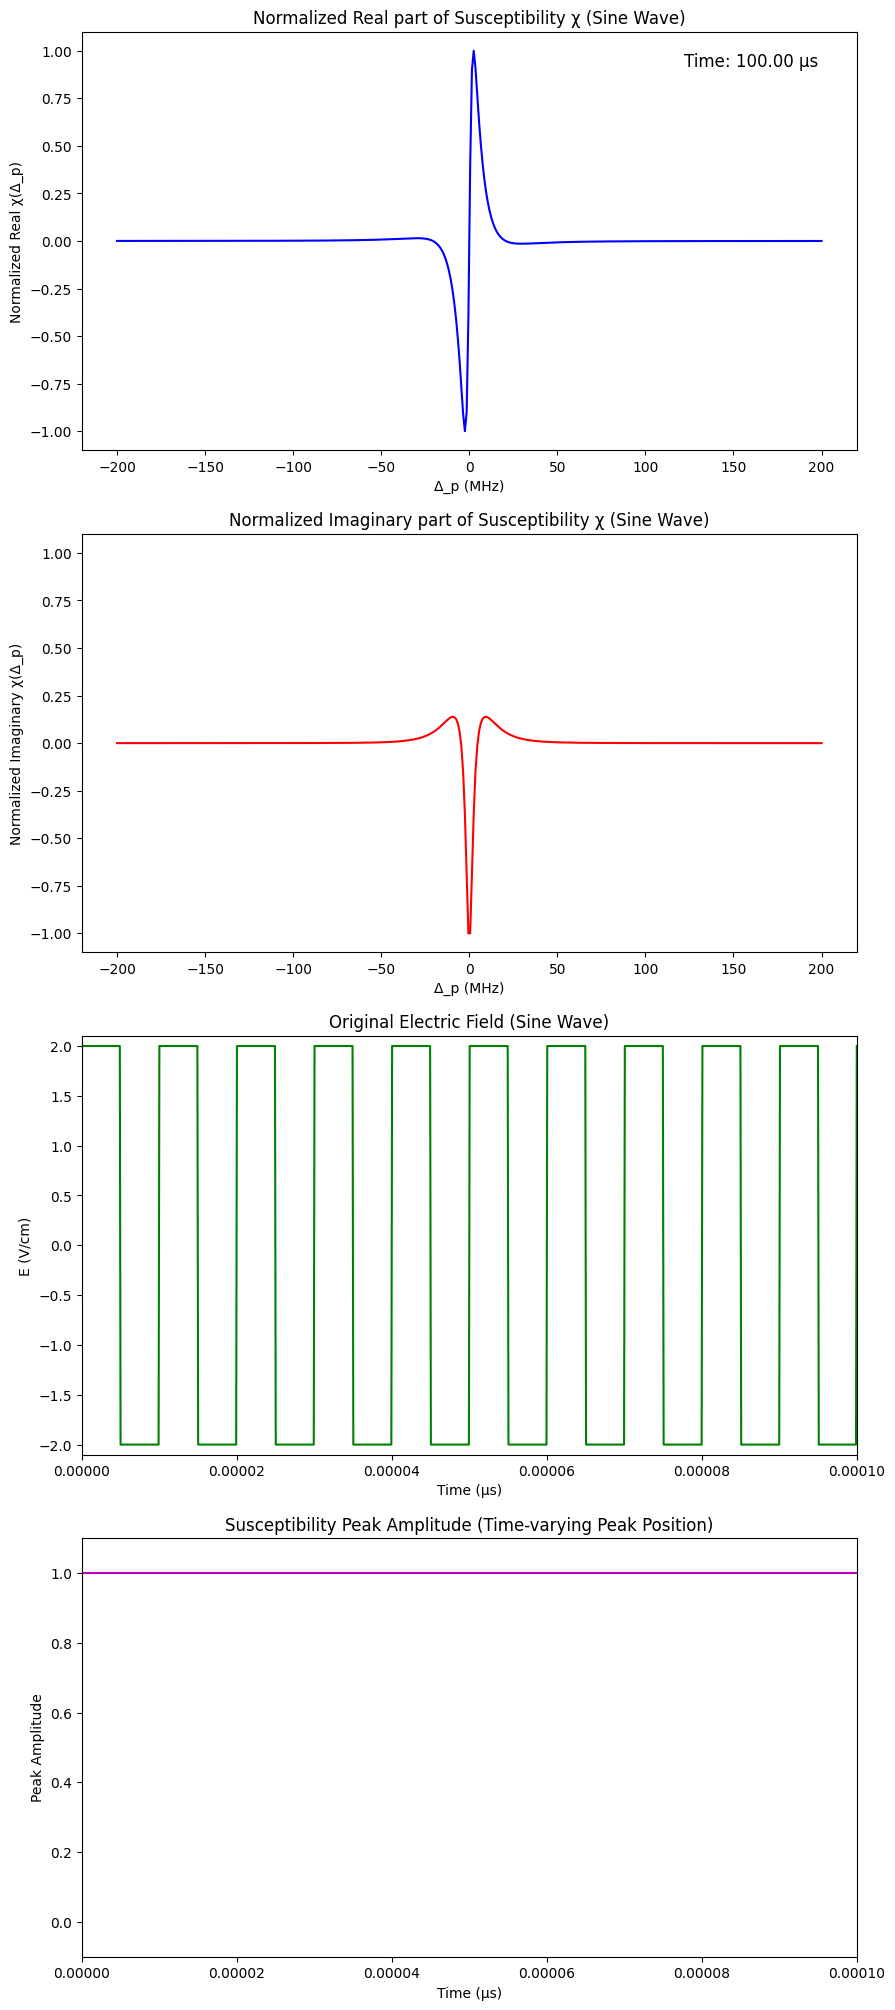

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, square  # square 함수 추가
from matplotlib.animation import FuncAnimation

# 상수 및 변수 정의
hbar = 1.054571817e-34  # Planck constant (J·s)
c = 3e8  # light speed (m/s)
d_eg = 1.46513e-29  # excited state dipole moment
N0 = 3.93e23  # 원자 수 밀도
V = 3.64e-5  # volume (m^3)
epsilon_0 = 8.854e-12  # vacuum permeability (F/m)
T = 300  # temperature (K)
k_B = 1.38e-23  # Boltzman constant
m = 85.47 * 1.660539066e-27  # Rubidium mass (kg)

alpha = 5.914e6  # polarizability of the Rydberg state (MHz / (V^2/cm^2))
frequency = 100e3  # 100 kHz (사각파의 주파수)
E_amplitude = 2  # 전기장의 진폭

omega_p = 3.774e14  # 795 nm probe frequency (Hz)
omega_c = 6.316e14  # 475 nm coupling frequency (Hz)
Omega_p = 2 * np.pi * 1e4  # probe laser Rabi frequency (Hz)
Omega_c = 2 * np.pi * 1.62 * 1e6  # coupling laser Rabi frequency (Hz)

gamma_p = 1e6  # probe laser linewidth
gamma_c = 1e6  # coupling laser linewidth
gamma_rel = (gamma_p + gamma_c) / 2

Gamma_e = 2 * np.pi * 5.75e6
Gamma_r = 1 / 7.06e-05

Delta_p_vals = np.linspace(-200, 200, 400)  # MHz
time_vals = np.linspace(0, 1e-4, 1000)  # 시간 범위, 0~100us

# High-pass filter 생성 함수
def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs  # 나이퀴스트 주파수
    normal_cutoff = cutoff / nyquist  # 정규화된 차단 주파수
    b, a = butter(order, normal_cutoff, btype='high', analog=False)  # 고역통과 필터로 변경
    return b, a

# High-pass filter 적용 함수
def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# 신호 생성 (사각파로 변경)
E_signal = E_amplitude * square(2 * np.pi * frequency * time_vals)  # 100 kHz 사각파 생성

# 고역 통과 필터 적용 (E_signal에 대해 필터링)
fs = 1e7  # 샘플링 주파수 (10 MHz)
cutoff = 1e6  # 차단 주파수 100 kHz
E_filtered = butter_highpass_filter(E_signal, cutoff, fs)

# Susceptibility 계산 함수
def calculate_chi(E):

    chi_real_vals_eit = []
    chi_imag_vals_eit = []
    chi_real_vals_abs = []
    chi_imag_vals_abs = []
    Delta_c = (2 * np.pi * (-1/2) * alpha * E ** 2)
    
    for dp in Delta_p_vals:
        Delta_p = dp * 1e6  # MHz to Hz
        denominator = (1/2) * Gamma_e + gamma_p - 1j * Delta_p +  (Omega_c**2/4) / (
                    (1/2) * Gamma_r + gamma_rel - 1j * (Delta_p + Delta_c) )
        chi = (1j * N0 * d_eg ** 2) / (epsilon_0 * hbar * denominator)
        chi_real_vals_eit.append(np.real(chi))
        chi_imag_vals_eit.append(np.imag(chi))

    # 기존 흡수신호 계산 (Omega_c = 0)
    for dp in Delta_p_vals:
        Delta_p = dp * 1e6  # MHz to Hz
        denominator_abs = (1/2) * Gamma_e + gamma_p - 1j * Delta_p  # Omega_c = 0
        chi_abs = (1j * N0 * d_eg ** 2) / (epsilon_0 * hbar * denominator_abs)
    
        chi_real_vals_abs.append(np.real(chi_abs))
        chi_imag_vals_abs.append(np.imag(chi_abs))

# EIT 신호에서 기존 흡수신호를 뺀 balanced detection 신호 계산
    chi_real_vals_balanced = [eit - abs_ for eit, abs_ in zip(chi_real_vals_eit, chi_real_vals_abs)]
    chi_imag_vals_balanced = [eit - abs_ for eit, abs_ in zip(chi_imag_vals_eit, chi_imag_vals_abs)]

# 정규화
    max_real = np.max(np.abs(chi_real_vals_balanced))
    chi_real_vals_normalized = [x / max_real for x in chi_real_vals_balanced]

    max_imag = np.max(np.abs(chi_imag_vals_balanced))
    chi_imag_vals_normalized = [x / max_imag for x in chi_imag_vals_balanced]

    
    return chi_real_vals_normalized, chi_imag_vals_normalized


def update(frame, line_real, line_imag, time_text, line_E_signal, line_peak_amplitude, E_filtered, E_signal, peak_amplitudes):
    t = time_vals[frame]
    E = E_filtered[frame]  # EIT 신호에 적용된 필터링된 전기장
    
    # Susceptibility 계산
    chi_real_vals_normalized, chi_imag_vals_normalized = calculate_chi(E)
    line_real.set_ydata(chi_real_vals_normalized)
    line_imag.set_ydata(chi_imag_vals_normalized)

    # 전기장 신호 업데이트
    line_E_signal.set_data(time_vals[:frame + 1], E_signal[:frame + 1])
    
    # X 축 업데이트
    if frame > 0:
        ax3.set_xlim(0, time_vals[frame])

    # 피크 진폭 계산 및 업데이트 (Imaginary 부분만 사용)
    total_chi = np.abs(chi_imag_vals_normalized)
    peak_index = np.argmax(total_chi)
    peak_amplitude = total_chi[peak_index]
    peak_amplitudes.append(peak_amplitude)
    
    # 시간 배열 길이와 진폭 배열 길이 일치
    line_peak_amplitude.set_data(time_vals[:frame + 1], peak_amplitudes[:frame + 1])
    if frame > 0:
        ax4.set_xlim(0, time_vals[frame])

    # 시간 텍스트 업데이트
    time_text.set_text(f'Time: {t * 1e6:.2f} µs')

    return line_real, line_imag, time_text, line_E_signal, line_peak_amplitude



# 그래프 그리기 및 애니메이션 설정
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 25))

# EIT 신호 (필터링된 전기장에 대한)
ax1.set_title('Normalized Real part of Susceptibility χ (Square Wave)')
ax1.set_xlabel('Δ_p (MHz)')
ax1.set_ylabel('Normalized Real χ(Δ_p)')
line_real, = ax1.plot(Delta_p_vals, np.zeros_like(Delta_p_vals), 'b')

ax2.set_title('Normalized Imaginary part of Susceptibility χ (Square Wave)')
ax2.set_xlabel('Δ_p (MHz)')
ax2.set_ylabel('Normalized Imaginary χ(Δ_p)')
line_imag, = ax2.plot(Delta_p_vals, np.zeros_like(Delta_p_vals), 'r')

# 새로운 전기장 신호 그래프 (원본 사인파)
ax3.set_title('Original Electric Field (Square Wave)')
ax3.set_xlabel('Time (µs)')
ax3.set_ylabel('E (V/cm)')
line_E_signal, = ax3.plot([], [], 'g')

# susceptibility 피크 진폭 변화 그래프
ax4.set_title('Susceptibility Peak Amplitude (Time-varying Peak Position)')
ax4.set_xlabel('Time (µs)')
ax4.set_ylabel('Peak Amplitude')
line_peak_amplitude, = ax4.plot([], [], 'm')

# ** 축 범위 조정 **
ax1.set_ylim([-1.1, 1.1])
ax2.set_ylim([-1.1, 1.1])
ax3.set_ylim([-2.1, 2.1])
ax4.set_ylim([-0.1, 1.1])
  # 피크 진폭 변화 범위 설정

# 피크 진폭을 저장할 리스트 초기화
peak_amplitudes = []

# 시간 표시 텍스트 추가 (우측 상단)
time_text = ax1.text(0.95, 0.95, '', transform=ax1.transAxes, fontsize=12, ha='right', va='top')

# 애니메이션 생성
ani_sine = FuncAnimation(
    fig, update, frames=len(time_vals), fargs=(line_real, line_imag, time_text, line_E_signal, line_peak_amplitude, E_filtered, E_signal, peak_amplitudes), interval=10)

# 애니메이션을 GIF로 저장
ani_sine.save('eit_signal_with_filtered_and_original_square_and_peak_amplitude.gif', writer='pillow')

plt.show()
